In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
import warnings

try:
    from dask_ml.cluster import KMeans as DaskKMeans
    from dask_ml.preprocessing import StandardScaler as DaskStandardScaler
    DASK_ML_AVAILABLE = True
    print("Dask-ML is available")
except ImportError:
    from sklearn.cluster import KMeans, DBSCAN
    from sklearn.preprocessing import StandardScaler
    DASK_ML_AVAILABLE = False
    print("Dask-ML is not available, using scikit-learn")

from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

warnings.filterwarnings('ignore')
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (20, 5)

Dask-ML is available


In [2]:
try:
    client = Client(processes=False, threads_per_worker=2, n_workers=1, memory_limit='1GB')
    print(f"Dask Client started: {client.dashboard_link}")
except:
    print("Using without Dask distributed client")


Dask Client started: http://192.168.1.36:8787/status


2025-08-16 13:47:03,301 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 4660d7d64c130885b194aa6588741f3d initialized by task ('shuffle-transfer-4660d7d64c130885b194aa6588741f3d', 0) executed on worker inproc://192.168.1.36/14972/4
2025-08-16 13:47:03,567 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 4660d7d64c130885b194aa6588741f3d deactivated due to stimulus 'task-finished-1755341223.5627391'
2025-08-16 13:47:03,987 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle aa4fa81671328bcaf76f900f23e087d9 initialized by task ('shuffle-transfer-aa4fa81671328bcaf76f900f23e087d9', 0) executed on worker inproc://192.168.1.36/14972/4
2025-08-16 13:47:04,194 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle aa4fa81671328bcaf76f900f23e087d9 deactivated due to stimulus 'task-finished-1755341224.1895802'
2025-08-16 13:47:12,438 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 358e424b9daf7fbd571a50a19699c241 initialized by task ('shuffle-transfe

In [3]:
file_path = r'../data/sales.csv'

data = None
is_dask = False

try:
    print("Loading file with Dask...")
    data = dd.read_csv(file_path, dtype={'week.year': str}, sep=';', decimal=',')

    if hasattr(data, 'compute'):
        is_dask = True
        print("File loaded successfully with Dask.")
        print()

        with ProgressBar():
            print(data.head().compute())
    else:
        print("Loaded as Pandas DataFrame, converting to Dask...")
        data = dd.from_pandas(data, npartitions=4)
        is_dask = True
        print("Converted to Dask.")
        print(data.head())

except FileNotFoundError:
    print(f"Error: File not found! Please check the path: {file_path}")
    exit()
except Exception as e:
    print(f"Dask loading error: {e}")
    print("Trying to load with Pandas...")

    try:
        data_pd = pd.read_csv(file_path, dtype={'week.year': str}, sep=';', decimal=',')
        data = dd.from_pandas(data_pd, npartitions=4)
        is_dask = True
        print("Loaded with Pandas and converted to Dask.")
        print(data.head())

    except Exception as e2:
        print(f"Pandas loading also failed: {e2}")
        exit()

if data is None:
    print("File could not be loaded!")
    exit()

print(f"Data type: {'Dask DataFrame' if is_dask else 'Pandas DataFrame'}")

Loading file with Dask...
File loaded successfully with Dask.

Dask loading error: 'DataFrame' object has no attribute 'compute'
Trying to load with Pandas...
Loaded with Pandas and converted to Dask.
  country       id week.year  revenue  units
0      KR   702234   03.2019   808.08      1
1      KR   702234   06.2019  1606.80      2
2      KR  3618438   08.2019   803.40      1
3      KR  3618438   09.2019   803.40      1
4      KR  3618438   09.2019   803.40      1
Data type: Dask DataFrame


In [4]:
print("\nLast 5 rows:")
if is_dask:
    with ProgressBar():
        print(data.tail())
else:
    print(data.tail())

print()
if is_dask:
    from dask import compute
    shape = compute(data.shape)[0]
else:
    shape = data.shape
print(f"Data shape: {shape}")

print("\nData info:")
print(f"Columns: {list(data.columns)}")
print(f"Data types:")
if is_dask:
    for col, dtype in data.dtypes.items():
        print(f"  {col}: {dtype}")
else:
    for col, dtype in data.dtypes.items():
        print(f"  {col}: {dtype}")


Last 5 rows:
       country       id week.year  revenue  units
235569      CN  2452476   27.2020  41160.0    200
235570      CN  2452476   27.2020  50856.0    400
235571      CN  2452476   27.2020  79920.0   1200
235572      CN  4553904   27.2020   4788.0    100
235573      CN  4553904   27.2020   4188.0    100

Data shape: (235574, 5)

Data info:
Columns: ['country', 'id', 'week.year', 'revenue', 'units']
Data types:
  country: string
  id: int64
  week.year: string
  revenue: float64
  units: int64


In [5]:
print("\nSeparating Week.year column...")

if hasattr(data, 'compute'):
    data = data.assign(
        week=data['week.year'].astype(str).str.split('.').str[0],
        year=data['week.year'].astype(str).str.split('.').str[1]
    )
    print("First 5 rows (after week/year separation):")
    with ProgressBar():
        head_data = data.head(5)
        print(head_data)
else:
    data[['week', 'year']] = data['week.year'].astype(str).str.split('.', expand=True)
    print("First 5 rows (after week/year separation):")
    print(data.head())


Separating Week.year column...
First 5 rows (after week/year separation):
  country       id week.year  revenue  units week  year
0      KR   702234   03.2019   808.08      1   03  2019
1      KR   702234   06.2019  1606.80      2   06  2019
2      KR  3618438   08.2019   803.40      1   08  2019
3      KR  3618438   09.2019   803.40      1   09  2019
4      KR  3618438   09.2019   803.40      1   09  2019


In [6]:
print("\nCreating date column...")
if is_dask:
    date_str = data['year'].astype(str) + '-W' + data['week'].astype(str) + '-1'
    data = data.assign(date=dd.to_datetime(date_str, format='%Y-W%W-%w'))
else:
    data['date'] = pd.to_datetime(
        data['year'].astype(str) + '-W' + data['week'].astype(str) + '-1',
        format='%Y-W%W-%w'
    )

print("First 5 rows (after adding date):")
if is_dask:
    with ProgressBar():
        head_data = data.head()
        print(head_data)
else:
    print(data.head())

print()
print(f"Columns: {list(data.columns)}")


Creating date column...
First 5 rows (after adding date):
  country       id week.year  revenue  units week  year       date
0      KR   702234   03.2019   808.08      1   03  2019 2019-01-21
1      KR   702234   06.2019  1606.80      2   06  2019 2019-02-11
2      KR  3618438   08.2019   803.40      1   08  2019 2019-02-25
3      KR  3618438   09.2019   803.40      1   09  2019 2019-03-04
4      KR  3618438   09.2019   803.40      1   09  2019 2019-03-04

Columns: ['country', 'id', 'week.year', 'revenue', 'units', 'week', 'year', 'date']


In [7]:
is_dask = isinstance(data, dd.DataFrame)
print(f"Data type check: is_dask = {is_dask}")
print(f"Actual data type: {type(data)}")

if is_dask:
    data2 = data.drop(['week.year', 'week', 'year'], axis=1)
    data2 = data2.rename(columns={
        'id': 'customer_id',
        'revenue': 'monetary',
        'units': 'quantity',
        'date': 'purchase_date'
    })
else:
    data2 = data.drop(['week.year', 'week', 'year'], axis=1)
    data2.rename(columns={
        'id': 'customer_id',
        'revenue': 'monetary',
        'units': 'quantity',
        'date': 'purchase_date'
    }, inplace=True)

print("Data info (after cleaning):")
print(f"Columns: {list(data2.columns)}")
print(f"Shape: {data2.shape}")

print()
print("New column names:")
print(list(data2.columns))

print()
print("Missing values:")
if is_dask:
    from dask.diagnostics import ProgressBar
    with ProgressBar():
        print(data2.isnull().sum().compute())
else:
    print(data2.isnull().sum())

print()
print("First 5 rows (final):")
if is_dask:
    print(data2.head())
else:
    print(data2.head())

print(f"\ndata2 type after processing: {type(data2)}")
print(f"Is data2 a Dask DataFrame: {isinstance(data2, dd.DataFrame)}")

Data type check: is_dask = True
Actual data type: <class 'dask.dataframe.dask_expr._collection.DataFrame'>
Data info (after cleaning):
Columns: ['country', 'customer_id', 'monetary', 'quantity', 'purchase_date']
Shape: (<dask_expr.expr.Scalar: expr=(RenameFrame(frame=Drop(frame=Assign(frame=Assign(frame=df)), columns=['week.year', 'week', 'year']), columns={'id': 'customer_id', 'revenue': 'monetary', 'units': 'quantity', 'date': 'purchase_date'})).size() // 5, dtype=int64>, 5)

New column names:
['country', 'customer_id', 'monetary', 'quantity', 'purchase_date']

Missing values:
country          0
customer_id      0
monetary         0
quantity         0
purchase_date    0
dtype: int64

First 5 rows (final):
  country  customer_id  monetary  quantity purchase_date
0      KR       702234    808.08         1    2019-01-21
1      KR       702234   1606.80         2    2019-02-11
2      KR      3618438    803.40         1    2019-02-25
3      KR      3618438    803.40         1    2019-03-0

In [8]:
print("\nDescriptive statistics:")
if is_dask:
    with ProgressBar():
        print(data2.describe().compute())
else:
    print(data2.describe())


Descriptive statistics:
        customer_id      monetary       quantity        purchase_date
count  2.355740e+05  2.355740e+05  235574.000000               235574
mean   3.193118e+06  2.840211e+03       8.599642                  NaN
std    7.371744e+06  2.247532e+04     602.939290                  NaN
min    6.000180e+05 -1.061539e+05 -150000.000000  2019-01-07 00:00:00
25%    2.734296e+06  6.124200e+02       1.000000  2019-07-08 00:00:00
50%    3.231744e+06  1.203870e+03       1.000000  2020-01-06 00:00:00
75%    3.928908e+06  2.377440e+03       2.000000  2020-05-04 00:00:00
max    2.419308e+08  2.415857e+06  150000.000000  2020-11-30 00:00:00


In [9]:
if is_dask:
    with ProgressBar():
        min_date = data2['purchase_date'].min().compute()
        max_date = data2['purchase_date'].max().compute()
else:
    min_date = data2['purchase_date'].min()
    max_date = data2['purchase_date'].max()

print(f"Earliest date in dataset: {min_date}")
print(f"Latest date in dataset: {max_date}")

Earliest date in dataset: 2019-01-07 00:00:00
Latest date in dataset: 2020-11-30 00:00:00


In [10]:
if is_dask:
    with ProgressBar():
        unique_countries = data2['country'].unique().compute()
        unique_countries_count = data2['country'].nunique().compute()
else:
    unique_countries = data2['country'].unique()
    unique_countries_count = data2['country'].nunique()

print(f"Unique countries: {unique_countries}")
print()
print(f"Number of unique countries: {unique_countries_count}")

country_map = {
    'AF': 'Afghanistan', 'BD': 'Bangladesh', 'CN': 'China', 'IN': 'India',
    'ID': 'Indonesia', 'IQ': 'Iraq', 'IR': 'Iran', 'JP': 'Japan',
    'KR': 'South Korea', 'MY': 'Malaysia', 'MM': 'Myanmar', 'PH': 'Philippines',
    'PK': 'Pakistan', 'SA': 'Saudi Arabia', 'TH': 'Thailand', 'TR': 'Turkey',
    'UZ': 'Uzbekistan', 'VN': 'Vietnam'
}

print("Mapping countries...")

if is_dask:
    print("Temporarily converting to Pandas for string operations...")
    with ProgressBar():
        data2_pd = data2.compute()
else:
    data2_pd = data2.copy()

data2_pd['country_clean'] = data2_pd['country'].map(country_map)
data2_pd['new_id'] = data2_pd['country'].fillna('') + '-' + data2_pd['customer_id'].fillna('').astype(str)

print("Matched country names:")
print(data2_pd['country_clean'].unique())
print()
print(f"Unique customer count: {data2_pd['customer_id'].nunique()}")

data2_pd['country'] = data2_pd['country_clean']
data2_pd = data2_pd.drop(columns=['country_clean'])

Unique countries: 0    JP
1    IR
0    VN
0    SA
1    PH
2    CN
3    BD
4    ID
5    TH
6    IQ
7    UZ
0    KR
1    PK
2    MM
3    IN
4    AF
5    MY
6    TR
Name: country, dtype: string

Number of unique countries: 18
Mapping countries...
Temporarily converting to Pandas for string operations...
Matched country names:
['South Korea' 'Pakistan' 'Myanmar' 'Vietnam' 'India' 'Saudi Arabia'
 'Philippines' 'Afghanistan' 'China' 'Bangladesh' 'Indonesia' 'Thailand'
 'Iraq' 'Malaysia' 'Japan' 'Iran' 'Turkey' 'Uzbekistan']

Unique customer count: 21837


In [11]:
print("Setting purchase_date as index...")
if is_dask:
    data3 = data2.set_index("purchase_date")
else:
    data3 = data2.set_index("purchase_date")

print("Data with index set:")
print(data3.head())

print(f"\nIndex type: {type(data3.index)}")
print(f"Index name: {data3.index.name}")

Setting purchase_date as index...
Data with index set:
              country  customer_id  monetary  quantity
purchase_date                                         
2019-01-07         PH      3935982    615.24         1
2019-01-07         ID      3470544    166.74         1
2019-01-07         CN      2490192    216.00         1
2019-01-07         ID      3346632    332.04         2
2019-01-07         TH      2195970    228.00         1

Index type: <class 'dask.dataframe.dask_expr._collection.Index'>
Index name: purchase_date


In [12]:
if is_dask:
    print(f"Data type: {type(data3)}")
    print(f"Columns: {list(data3.columns)}")
    
    print("\nSome statistics (with compute()):")
    with ProgressBar():
        print(f"Total number of rows: {len(data3)}")
        print(f"Index range:")
        print(f"  Min: {data3.index.min().compute()}")
        print(f"  Max: {data3.index.max().compute()}")
else:
    print(f"Total number of rows: {len(data3)}")
    print(f"Index range: {data3.index.min()} - {data3.index.max()}")

Data type: <class 'dask.dataframe.dask_expr._collection.DataFrame'>
Columns: ['country', 'customer_id', 'monetary', 'quantity']

Some statistics (with compute()):
Total number of rows: 235574
Index range:
  Min: 2019-01-07 00:00:00
  Max: 2020-11-30 00:00:00


Preparing data for weekly analysis...


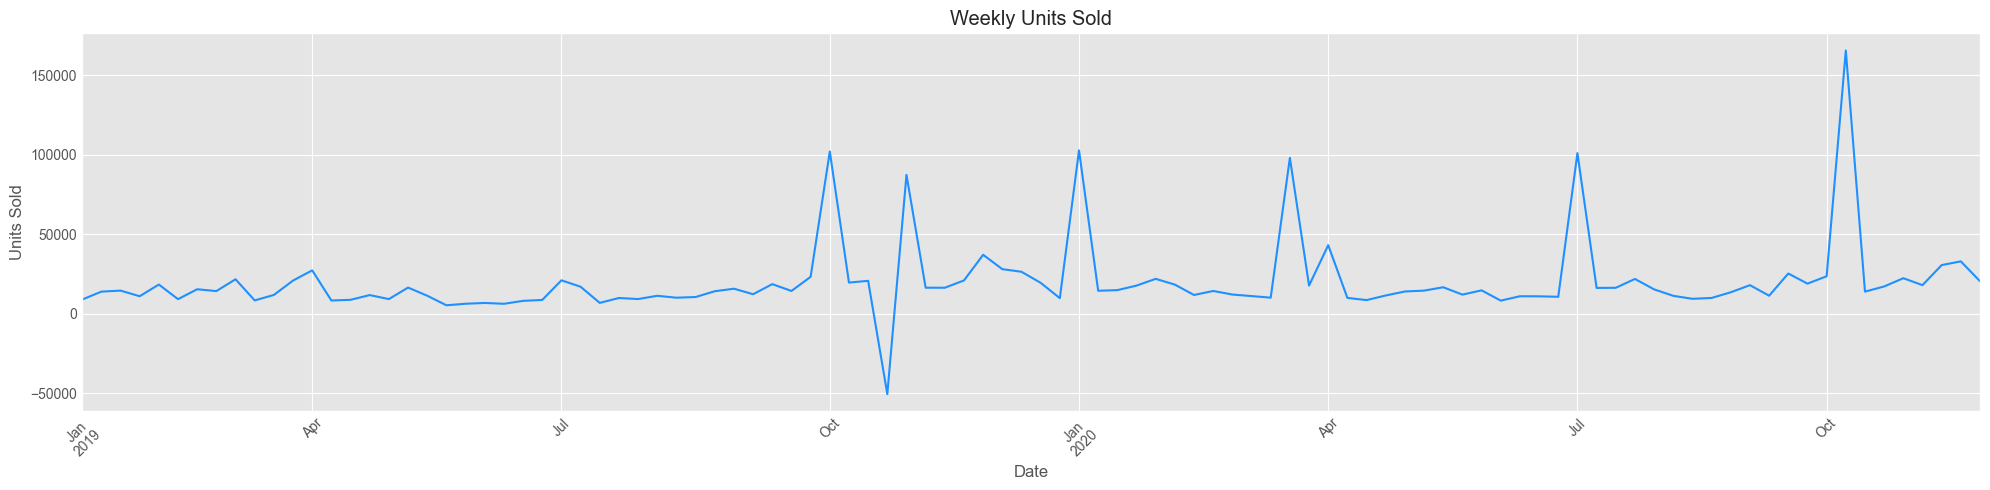

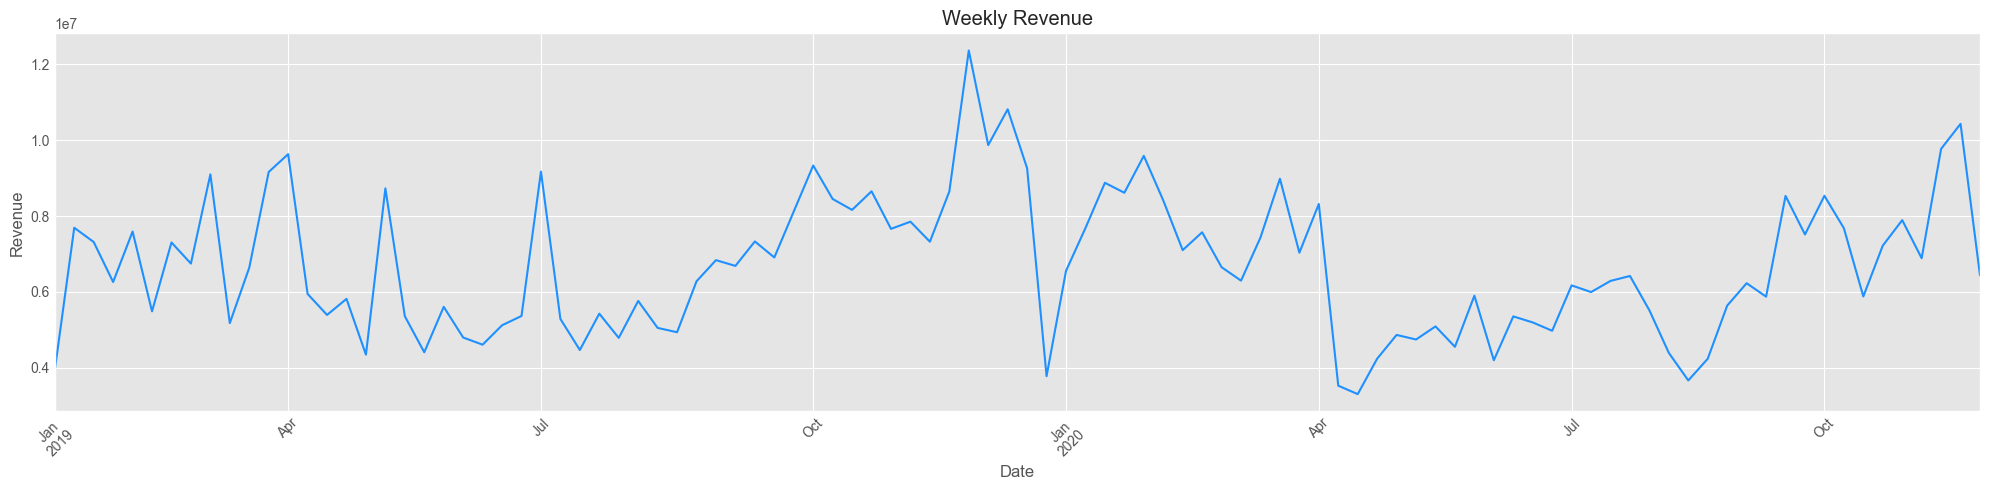

In [13]:
print("Preparing data for weekly analysis...")
if is_dask:
    with ProgressBar():
        weekly_quantity = data2.groupby('purchase_date')['quantity'].sum().compute()
        weekly_revenue = data2.groupby('purchase_date')['monetary'].sum().compute()
else:
    weekly_quantity = data2.groupby('purchase_date')['quantity'].sum()
    weekly_revenue = data2.groupby('purchase_date')['monetary'].sum()

plt.style.use('ggplot')
plt.figure(figsize=(20, 5))
weekly_quantity.plot(color='dodgerblue')
plt.title('Weekly Units Sold')
plt.ylabel('Units Sold')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 5))
weekly_revenue.plot(color='dodgerblue')
plt.title('Weekly Revenue')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Preparing data for monthly analysis...
Sample monthly data:
              country  customer_id  monetary  quantity
purchase_date                                         
2019-01            TH    3872490.0   1109.04       1.0
2019-01            PH    1190274.0    612.90       1.0
2019-01            BD    4232220.0    612.54       1.0
2019-01            PH    1190316.0    612.90       1.0
2019-01            PH    1190328.0    612.90       1.0


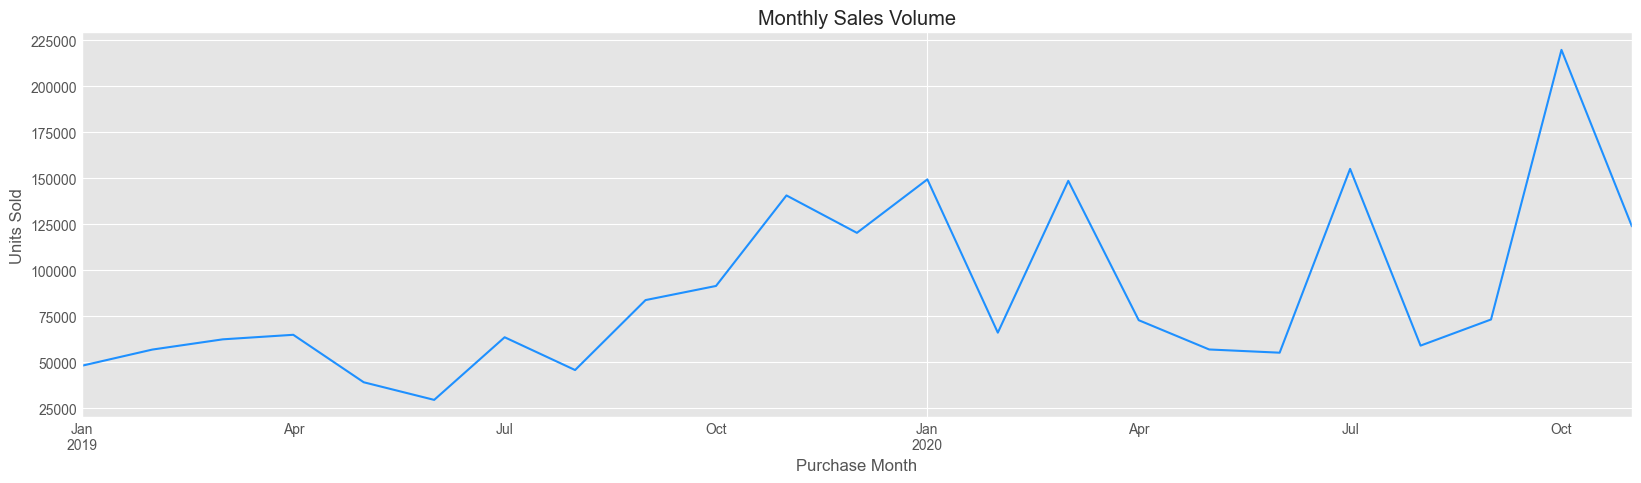

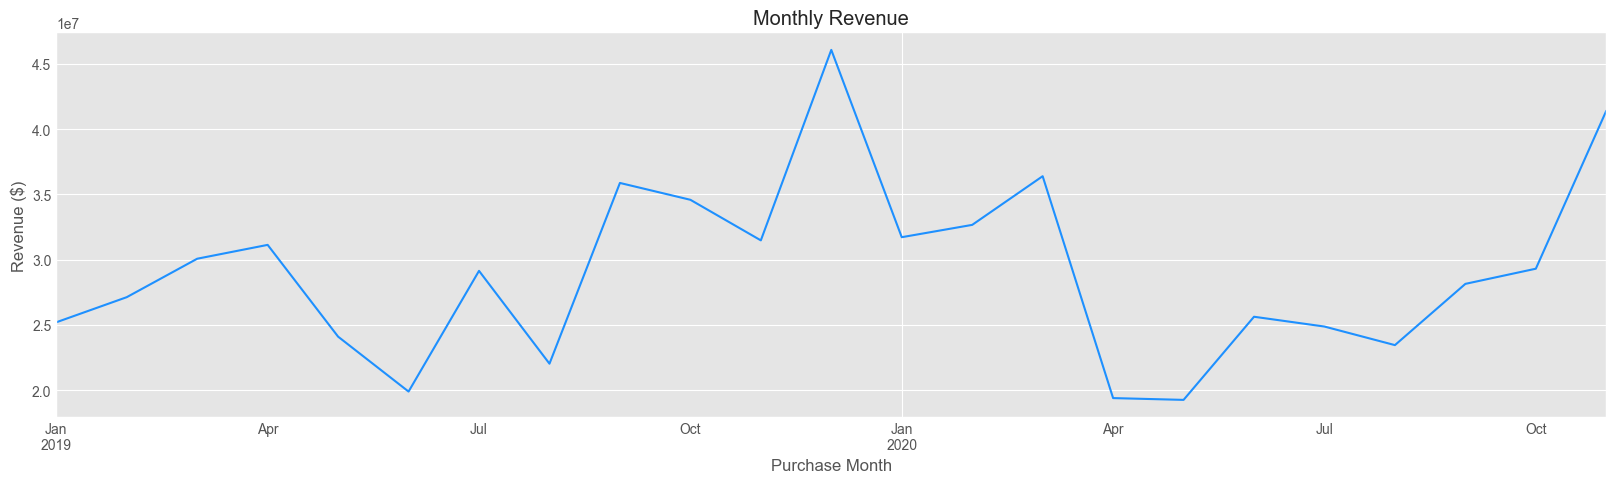

In [14]:
print("Preparing data for monthly analysis...")
if is_dask:
    with ProgressBar():
        data4_pd = data3.compute().to_period("M")
else:
    data4_pd = data3.to_period("M")

print("Sample monthly data:")
print(data4_pd.head())

plt.figure(figsize=(20, 5))
data4_pd['quantity'].groupby('purchase_date').sum().plot(color='dodgerblue')
plt.title('Monthly Sales Volume')
plt.ylabel('Units Sold')
plt.xlabel('Purchase Month')
plt.show()

plt.figure(figsize=(20, 5))
data4_pd['monetary'].groupby('purchase_date').sum().plot(color='dodgerblue')
plt.title('Monthly Revenue')
plt.ylabel('Revenue ($)')
plt.xlabel('Purchase Month')
plt.show()

In [15]:
if is_dask:
    with ProgressBar():
        min_date = data2['purchase_date'].min().compute()
        max_date = data2['purchase_date'].max().compute()
else:
    min_date = data2['purchase_date'].min()
    max_date = data2['purchase_date'].max()

print('Sales from {} to {}'.format(min_date, max_date))

Sales from 2019-01-07 00:00:00 to 2020-11-30 00:00:00


In [16]:
period = 365
if is_dask:
    with ProgressBar():
        max_purchase_date = data2['purchase_date'].max().compute()
else:
    max_purchase_date = data2['purchase_date'].max()

date_N_days_ago = max_purchase_date - timedelta(days=period)

if is_dask:
    data2_filtered = data2[data2['purchase_date'] > date_N_days_ago]
    with ProgressBar():
        data2_filtered = data2_filtered.compute()
        data2_filtered.reset_index(drop=True, inplace=True)
else:
    data2_filtered = data2[data2['purchase_date'] > date_N_days_ago]
    data2_filtered.reset_index(drop=True, inplace=True)

print("Filtered data:")
print(data2_filtered.head())
print()
print("Filtered data info:")
print(f"Shape: {data2_filtered.shape}")

Filtered data:
  country  customer_id  monetary  quantity purchase_date
0      KR      4375152    773.58         1    2019-12-16
1      KR       705462    337.26         1    2019-12-09
2      KR       705462    337.26         1    2019-12-23
3      KR       705462    421.56         2    2019-12-16
4      KR       706854    391.50         1    2019-12-09

Filtered data info:
Shape: (124640, 5)


In [17]:
try:
    data5 = data2_filtered.copy()
except NameError:
    print("data2_filtered not found, using data2 instead")
    data5 = data2.copy()

data5['new_id'] = data5['country'] + '-' + data5['customer_id'].astype(str)

NOW = data5['purchase_date'].max() + timedelta(days=1)
print(f"Analysis date (NOW): {NOW}")

if data5['purchase_date'].dtype == 'object':
    data5['purchase_date'] = pd.to_datetime(data5['purchase_date'])

data5['days_since_purchase'] = (NOW - data5['purchase_date']).dt.days

print("Days since purchase added:")
print(data5.head())

print(f"\nUnique new_id count: {data5['new_id'].nunique()}")
print(f"Sample new_id values: {data5['new_id'].head().tolist()}")

sample_customer_id = data5['new_id'].iloc[4]
sample_customer_data = data5[data5['new_id'] == sample_customer_id]
print(f"\nSample customer data (ID: {sample_customer_id}):")
print(sample_customer_data)

print("\nStarting RFM aggregation...")

Analysis date (NOW): 2020-12-01 00:00:00
Days since purchase added:
  country  customer_id  monetary  quantity purchase_date      new_id  \
0      KR      4375152    773.58         1    2019-12-16  KR-4375152   
1      KR       705462    337.26         1    2019-12-09   KR-705462   
2      KR       705462    337.26         1    2019-12-23   KR-705462   
3      KR       705462    421.56         2    2019-12-16   KR-705462   
4      KR       706854    391.50         1    2019-12-09   KR-706854   

   days_since_purchase  
0                  351  
1                  358  
2                  344  
3                  351  
4                  358  

Unique new_id count: 16569
Sample new_id values: ['KR-4375152', 'KR-705462', 'KR-705462', 'KR-705462', 'KR-706854']

Sample customer data (ID: KR-706854):
      country  customer_id  monetary  quantity purchase_date     new_id  \
4          KR       706854    391.50         1    2019-12-09  KR-706854   
5          KR       706854    388.68       

In [18]:
period = 365

rfm = (
    data5
    .groupby(['customer_id', 'new_id', 'country'])
    .agg({
        'days_since_purchase': 'min',
        'purchase_date': 'count',
        'monetary': 'sum'
    })
    .reset_index()
    .rename(columns={
        'days_since_purchase': 'recency',
        'purchase_date': 'frequency',
        'monetary': 'monetary'
    })
)

print("RFM core metrics:")
print(rfm.head())

print(f"\nRFM Summary:")
print(f"Total customers: {len(rfm)}")
print(f"Average recency: {rfm['recency'].mean():.1f} days")
print(f"Average frequency: {rfm['frequency'].mean():.1f} purchases")
print(f"Average monetary: {rfm['monetary'].mean():.2f}")

print(f"\nRFM Data Types:")
print(rfm.dtypes)

print(f"\nRFM Shape: {rfm.shape}")
print(f"Columns: {list(rfm.columns)}")

first_customer = rfm.iloc[0]
print(f"\nFirst customer details:")
print(f"Customer ID: {first_customer['customer_id']}")
print(f"Country: {first_customer['country']}")
print(f"Recency: {first_customer['recency']} days")
print(f"Frequency: {first_customer['frequency']} purchases")
print(f"Monetary: {first_customer['monetary']:.2f}")

RFM core metrics:
   customer_id     new_id country  recency  frequency  monetary
0       600018  CN-600018      CN       29          7  21402.78
1       600060  CN-600060      CN      155          1   1201.14
2       600462  CN-600462      CN      211          2   2033.64
3       600888  CN-600888      CN        8          3   2335.80
4       601014  CN-601014      CN      225          1    230.52

RFM Summary:
Total customers: 16569
Average recency: 118.3 days
Average frequency: 7.5 purchases
Average monetary: 21629.61

RFM Data Types:
customer_id              int64
new_id         string[pyarrow]
country        string[pyarrow]
recency                  int64
frequency                int64
monetary               float64
dtype: object

RFM Shape: (16569, 6)
Columns: ['customer_id', 'new_id', 'country', 'recency', 'frequency', 'monetary']

First customer details:
Customer ID: 600018
Country: CN
Recency: 29 days
Frequency: 7 purchases
Monetary: 21402.78


In [19]:
recent_data = data5[data5['purchase_date'] >= NOW - timedelta(days=period)]
monetary_sum = recent_data.groupby('new_id')['monetary'].sum()
rfm['monetary'] = rfm['new_id'].map(monetary_sum).fillna(0)

print("RFM with monetary added:")
print(rfm.head())
print()

max_monetary = rfm['monetary'].max()
print("Highest monetary customer(s):")
print(rfm[rfm['monetary'] == max_monetary])
print()

max_frequency = rfm['frequency'].max()
print("Highest frequency customer(s):")
print(rfm[rfm['frequency'] == max_frequency])

rfm = rfm.drop(columns=['new_id'])

RFM with monetary added:
   customer_id     new_id country  recency  frequency  monetary
0       600018  CN-600018      CN       29          7  21402.78
1       600060  CN-600060      CN      155          1   1201.14
2       600462  CN-600462      CN      211          2   2033.64
3       600888  CN-600888      CN        8          3   2335.80
4       601014  CN-601014      CN      225          1    230.52

Highest monetary customer(s):
     customer_id     new_id country  recency  frequency     monetary
173       638544  CN-638544      CN        1        217  21482332.56

Highest frequency customer(s):
      customer_id      new_id country  recency  frequency    monetary
8290      3249114  TR-3249114      TR        1       1351  2731448.04


In [20]:
quintiles = rfm[['recency', 'frequency', 'monetary']].quantile([0.2, 0.4, 0.6, 0.8])
print("Quintiles:")
print(quintiles)

Quintiles:
     recency  frequency   monetary
0.2     15.0        1.0    967.500
0.4     50.0        2.0   2212.200
0.6    120.0        4.0   4852.548
0.8    239.0        9.0  13957.500


In [ ]:
def r_score(x):
    if x <= quintiles.loc[0.2, 'recency']:
        return 5
    elif x <= quintiles.loc[0.4, 'recency']:
        return 4
    elif x <= quintiles.loc[0.6, 'recency']:
        return 3
    elif x <= quintiles.loc[0.8, 'recency']:
        return 2
    else:
        return 1

def fm_score(x, column):
    if x <= quintiles.loc[0.2, column]:
        return 1
    elif x <= quintiles.loc[0.4, column]:
        return 2
    elif x <= quintiles.loc[0.6, column]:
        return 3
    elif x <= quintiles.loc[0.8, column]:
        return 4
    else:
        return 5

rfm['r'] = rfm['recency'].apply(r_score)
rfm['f'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['m'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

print("RFM scores:")
print(rfm.head())
print()

rfm['rfm_score'] = rfm[['r', 'f', 'm']].astype(str).agg(''.join, axis=1)
rfm['fm'] = ((rfm['f'] + rfm['m']) / 2).apply(math.trunc)

print("RFM and FM scores:")
print(rfm.head())

RFM scores:
   customer_id country  recency  frequency  monetary  r  f  m
0       600018      CN       29          7  21402.78  4  4  5
1       600060      CN      155          1   1201.14  2  1  2
2       600462      CN      211          2   2033.64  2  2  2
3       600888      CN        8          3   2335.80  5  3  3
4       601014      CN      225          1    230.52  2  1  1

RFM and FM scores:
   customer_id country  recency  frequency  monetary  r  f  m rfm_score  fm
0       600018      CN       29          7  21402.78  4  4  5       445   4
1       600060      CN      155          1   1201.14  2  1  2       212   1
2       600462      CN      211          2   2033.64  2  2  2       222   2
3       600888      CN        8          3   2335.80  5  3  3       533   3
4       601014      CN      225          1    230.52  2  1  1       211   1


In [22]:
segment_map = {
    '11': 'hibernating', '12': 'hibernating', '21': 'hibernating', '22': 'hibernating',
    '13': 'at risk', '14': 'at risk', '15': 'can\'t lose',
    '23': 'at risk', '24': 'at risk', '25': 'at risk',
    '31': 'about to sleep', '32': 'about to sleep', '33': 'need attention',
    '34': 'loyal customers', '35': 'loyal customers',
    '41': 'promising', '42': 'potential loyalists', '43': 'potential loyalists',
    '44': 'loyal customers', '45': 'loyal customers',
    '51': 'new customers', '52': 'potential loyalists', '53': 'potential loyalists',
    '54': 'loyal customers', '55': 'champions'
}

rfm['segment_key'] = rfm['r'].astype(str) + rfm['fm'].astype(str)
rfm['segment'] = rfm['segment_key'].map(segment_map)

unmapped = rfm[rfm['segment'].isna()]['segment_key'].unique()
if len(unmapped) > 0:
    print(f"Unmapped segment keys: {unmapped}")
    rfm['segment'] = rfm['segment'].fillna('other')

print("Segmentation completed:")
print(rfm.head())
print()
print("Null values check:")
print(rfm.isnull().sum())
print()
print(f"Unique segments: {rfm['segment'].unique()}")

Segmentation completed:
   customer_id country  recency  frequency  monetary  r  f  m rfm_score  fm  \
0       600018      CN       29          7  21402.78  4  4  5       445   4   
1       600060      CN      155          1   1201.14  2  1  2       212   1   
2       600462      CN      211          2   2033.64  2  2  2       222   2   
3       600888      CN        8          3   2335.80  5  3  3       533   3   
4       601014      CN      225          1    230.52  2  1  1       211   1   

  segment_key              segment  
0          44      loyal customers  
1          21          hibernating  
2          22          hibernating  
3          53  potential loyalists  
4          21          hibernating  

Null values check:
customer_id    0
country        0
recency        0
frequency      0
monetary       0
r              0
f              0
m              0
rfm_score      0
fm             0
segment_key    0
segment        0
dtype: int64

Unique segments: ['loyal customers' 'hibe

In [23]:
print("\nCan't lose customers (top by monetary):")
cant_lose = rfm[rfm['segment'] == "can't lose"].sort_values(by='monetary', ascending=False)
print(cant_lose)
print()

print("\nNeed attention customers (top 10 by monetary):")
need_attention = rfm[rfm['segment'] == 'need attention'].sort_values(by='monetary', ascending=False).head(10)
print(need_attention)
print()

print("\nLoyal customers (top 10 by monetary):")
loyal = rfm[rfm['segment'] == 'loyal customers'].sort_values(by='monetary', ascending=False).head(10)
print(loyal)
print()

print("\nChampions (top 10 by monetary):")
champions = rfm[rfm['segment'] == 'champions'].sort_values(by='monetary', ascending=False).head(10)
print(champions)


Can't lose customers (top by monetary):
       customer_id country  recency  frequency   monetary  r  f  m rfm_score  \
13028      4096386      JP      260        105  220267.86  1  5  5       155   
3502       2443284      IN      246         10  102208.02  1  5  5       155   
14174      4262646      IN      316         10   91909.44  1  5  5       155   
2435       1803672      IN      267         12   70506.96  1  5  5       155   
13254      4132968      VN      253         26   42535.14  1  5  5       155   
11222      3815274      IN      267         11   37968.72  1  5  5       155   
1458       1031454      PH      267         23   31833.30  1  5  5       155   
5437       2809158      IN      274         12   27150.12  1  5  5       155   
14644      4326906      IN      337         11   22351.68  1  5  5       155   
259         668070      MM      267         11   21886.92  1  5  5       155   
15331      4418268      SA      302         10   14295.54  1  5  5       155   

In [24]:
avg_monetary = rfm['monetary'].mean()
print(f"\nAverage monetary value: {avg_monetary:.2f}")

high_value_need_attention = rfm[
    (rfm['monetary'] > avg_monetary) & (rfm['segment'] == 'need attention')
].sort_values(by='monetary', ascending=False)

print(f"\nHigh-value 'need attention' customers:")
print(high_value_need_attention)


Average monetary value: 21629.61

High-value 'need attention' customers:
       customer_id country  recency  frequency  monetary  r  f  m rfm_score  \
8245       3242664      TR       64          1  73823.58  3  1  5       315   
13065      4107798      JP      120          2  67257.48  3  2  5       325   
9847       3561900      ID      120          1  59700.00  3  1  5       315   
6626       2921070      ID       71          2  34730.22  3  2  5       325   
10009      3587772      CN       92          1  29961.00  3  1  5       315   
3087       2131194      JP       57          1  28543.74  3  1  5       315   
13463      4160490      JP       99          1  24842.22  3  1  5       315   
1251        993414      KR       71          2  22018.32  3  2  5       325   

       fm segment_key         segment  
8245    3          33  need attention  
13065   3          33  need attention  
9847    3          33  need attention  
6626    3          33  need attention  
10009   3     

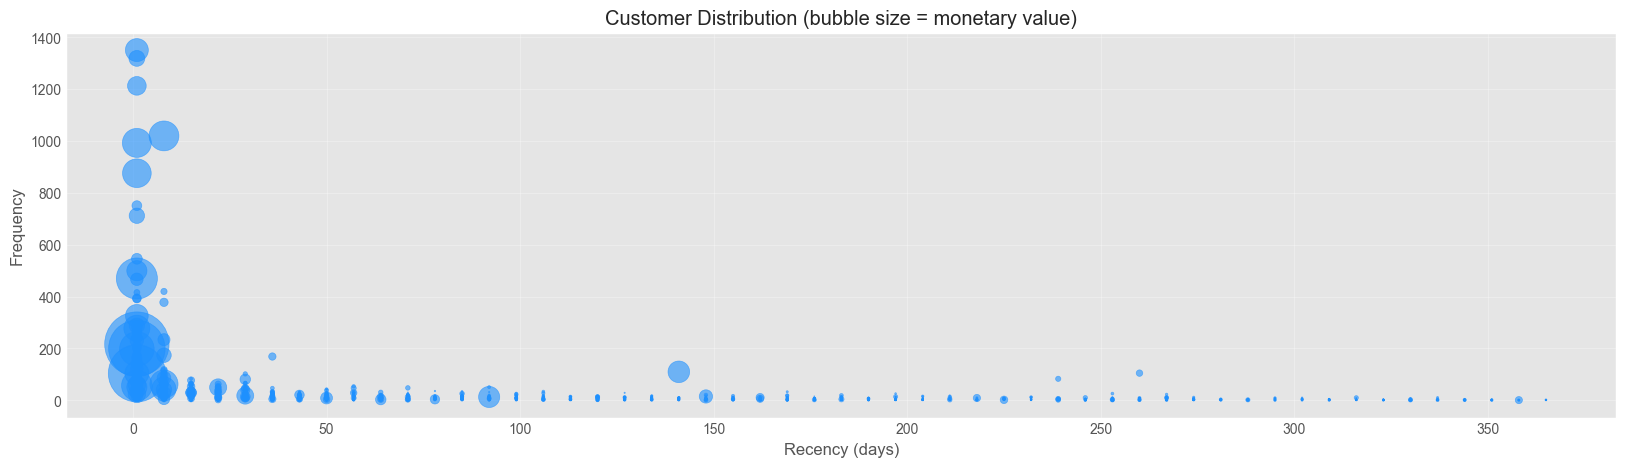

In [25]:
# Customer distribution scatter plot
plt.figure(figsize=(20, 5))
plt.scatter(rfm['recency'], rfm['frequency'], s=rfm['monetary']*0.0001, c='dodgerblue', alpha=0.6)
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.title('Customer Distribution (bubble size = monetary value)')
plt.grid(True, alpha=0.3)
plt.show()

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

print("Silhouette scores:", [round(s, 3) for s in silhouette_scores])

manual_k = 4
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal K based on silhouette score: {optimal_k}")
print(f"Manually selected K (more balanced): {manual_k}")

Silhouette scores: [0.969, 0.617, 0.617, 0.627, 0.549, 0.572, 0.572, 0.548, 0.509]
Optimal K based on silhouette score: 2
Manually selected K (more balanced): 4


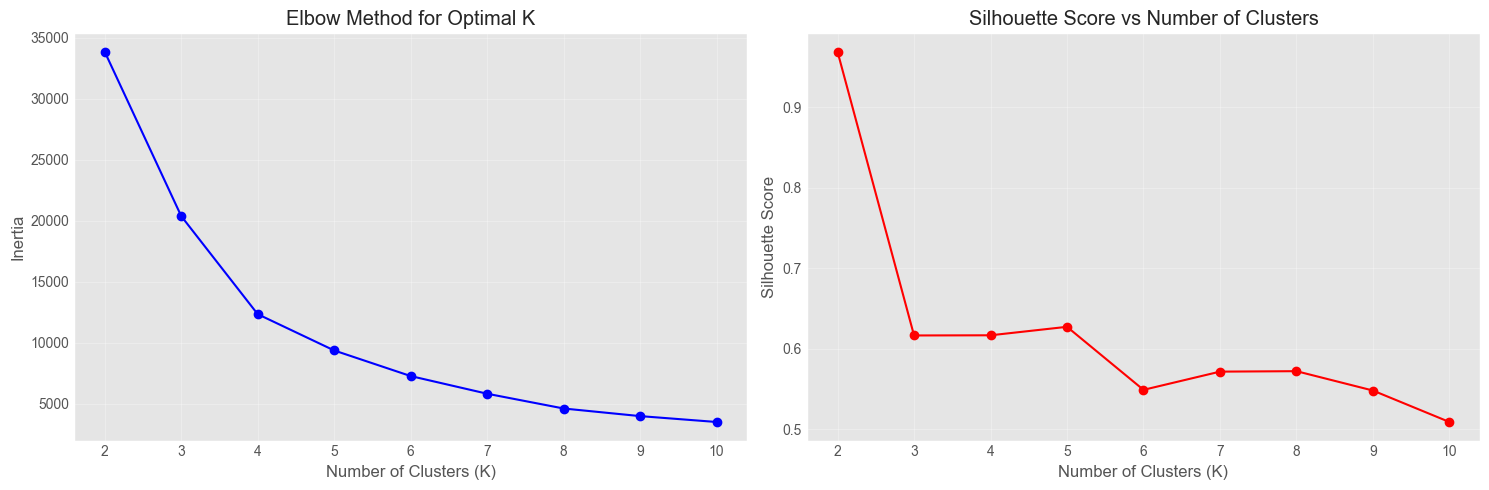


Final clustering with K=4:
Cluster distribution:
cluster
0    10689
1     5866
2        3
3       11
Name: count, dtype: int64


In [27]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_k = manual_k
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(rfm_scaled)

rfm['cluster'] = cluster_labels

print(f"\nFinal clustering with K={final_k}:")
print(f"Cluster distribution:")
print(rfm['cluster'].value_counts().sort_index())

In [28]:
optimal_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['kmeans_optimal'] = optimal_kmeans.fit_predict(rfm_scaled)

manual_kmeans = KMeans(n_clusters=manual_k, random_state=42, n_init=10)
rfm['kmeans_cluster'] = manual_kmeans.fit_predict(rfm_scaled)

print(f"\nOptimal K-Means (K={optimal_k}) cluster distribution:")
print(rfm['kmeans_optimal'].value_counts().sort_index())

print(f"\nManual K-Means (K={manual_k}) cluster distribution:")
print(rfm['kmeans_cluster'].value_counts().sort_index())

manual_cluster_balance = rfm['kmeans_cluster'].value_counts()
min_cluster_size = manual_cluster_balance.min()
max_cluster_size = manual_cluster_balance.max()
balance_ratio = min_cluster_size / max_cluster_size

print()
print(f"Manual clustering balance ratio: {balance_ratio:.3f}")
print(f"K-Means Manual Silhouette Score: {silhouette_score(rfm_scaled, rfm['kmeans_cluster']):.3f}")
print(f"K-Means Optimal Silhouette Score: {max(silhouette_scores):.3f}")


Optimal K-Means (K=2) cluster distribution:
kmeans_optimal
0    16556
1       13
Name: count, dtype: int64

Manual K-Means (K=4) cluster distribution:
kmeans_cluster
0    10689
1     5866
2        3
3       11
Name: count, dtype: int64

Manual clustering balance ratio: 0.000
K-Means Manual Silhouette Score: 0.617
K-Means Optimal Silhouette Score: 0.969


Optimal epsilon value: 0.037


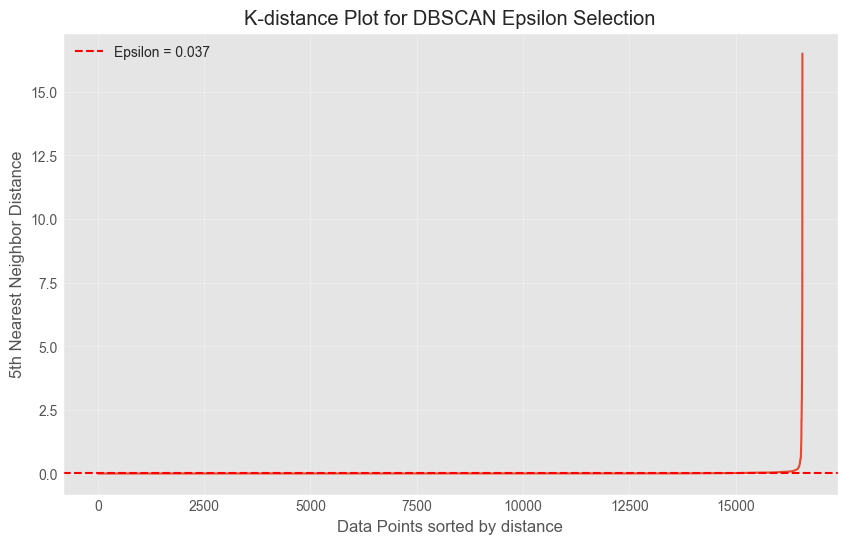

DBSCAN number of clusters: 86
Number of customers detected as noise by DBSCAN: 1460
Percentage of noise: 8.81%


In [29]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

epsilon = distances[int(len(distances) * 0.95)]
print(f"Optimal epsilon value: {epsilon:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=epsilon, color='r', linestyle='--', label=f'Epsilon = {epsilon:.3f}')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.title('K-distance Plot for DBSCAN Epsilon Selection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

dbscan = DBSCAN(eps=epsilon, min_samples=5)
rfm['dbscan_cluster'] = dbscan.fit_predict(rfm_scaled)

n_clusters_dbscan = len(set(rfm['dbscan_cluster'])) - (1 if -1 in rfm['dbscan_cluster'] else 0)
n_noise = list(rfm['dbscan_cluster']).count(-1)

print(f"DBSCAN number of clusters: {n_clusters_dbscan}")
print(f"Number of customers detected as noise by DBSCAN: {n_noise}")
print(f"Percentage of noise: {n_noise/len(rfm)*100:.2f}%")

In [30]:
kmeans_analysis = rfm.groupby('cluster').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(2)
kmeans_analysis.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']

print("\nK-Means Cluster Analysis:")
print(kmeans_analysis)

dbscan_analysis = rfm[rfm['dbscan_cluster'] != -1].groupby('dbscan_cluster').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(2)
dbscan_analysis.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']

print("\nDBSCAN Cluster Analysis (excluding noise):")
print(dbscan_analysis)


K-Means Cluster Analysis:
         Customer_Count  Avg_Recency  Avg_Frequency  Avg_Monetary
cluster                                                          
0                 10689        45.43           9.65      23321.20
1                  5866       251.43           1.91       3727.46
2                     3         1.00         173.67   18315217.64
3                    11         1.64         886.45    2935433.52

DBSCAN Cluster Analysis (excluding noise):
                Customer_Count  Avg_Recency  Avg_Frequency  Avg_Monetary
dbscan_cluster                                                          
0                          687         29.0           5.94       7913.21
1                          198        155.0           2.22       3464.08
2                          152        211.0           1.93       2155.96
3                         1177          8.0           9.29      13543.38
4                          134        225.0           1.69       2076.17
...                   


Cluster Comparison:
K-Means: 4 clusters
DBSCAN: 86 clusters + 1460 noise points


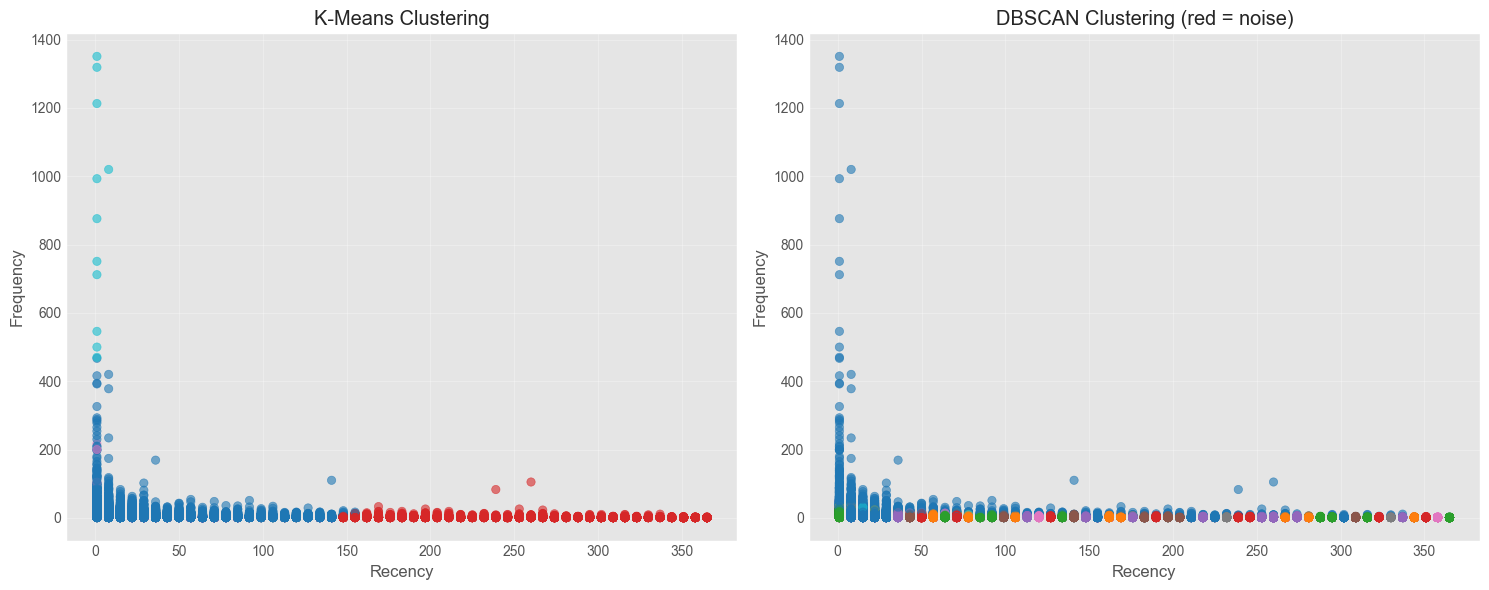

In [31]:
print(f"\nCluster Comparison:")
print(f"K-Means: {len(kmeans_analysis)} clusters")
print(f"DBSCAN: {n_clusters_dbscan} clusters + {n_noise} noise points")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

scatter1 = axes[0].scatter(rfm['recency'], rfm['frequency'], 
                          c=rfm['cluster'], cmap='tab10', alpha=0.6)
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')
axes[0].set_title('K-Means Clustering')
axes[0].grid(True, alpha=0.3)

scatter2 = axes[1].scatter(rfm['recency'], rfm['frequency'], 
                          c=rfm['dbscan_cluster'], cmap='tab10', alpha=0.6)
axes[1].set_xlabel('Recency')
axes[1].set_ylabel('Frequency')
axes[1].set_title('DBSCAN Clustering (red = noise)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
dbscan_clean = rfm[rfm['dbscan_cluster'] != -1]
if len(dbscan_clean) > 0:
    dbscan_analysis = dbscan_clean.groupby('dbscan_cluster').agg({
        'customer_id': 'count',
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': 'mean'
    }).round(2)
    dbscan_analysis.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']
    
    print("\nDBSCAN Cluster Analysis (excluding noise):")
    print(dbscan_analysis)


DBSCAN Cluster Analysis (excluding noise):
                Customer_Count  Avg_Recency  Avg_Frequency  Avg_Monetary
dbscan_cluster                                                          
0                          687         29.0           5.94       7913.21
1                          198        155.0           2.22       3464.08
2                          152        211.0           1.93       2155.96
3                         1177          8.0           9.29      13543.38
4                          134        225.0           1.69       2076.17
...                        ...          ...            ...           ...
80                           5          1.0          38.00      44518.06
81                           6          1.0          40.83      20014.77
82                           3         15.0          26.00      18833.52
83                           5          8.0          39.60      18151.49
84                           2         78.0          10.00      29106.27

[85 ro

In [33]:
cohort_data = data5.copy()
cohort_data['purchase_period'] = cohort_data['purchase_date'].dt.to_period('M')
cohort_data['cohort_group'] = cohort_data.groupby('customer_id')['purchase_date'].transform('min').dt.to_period('M')

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year * 12 + month

cohort_data['purchase_period_int'] = get_date_int(cohort_data, 'purchase_period')
cohort_data['cohort_group_int'] = get_date_int(cohort_data, 'cohort_group')
cohort_data['period_number'] = cohort_data['purchase_period_int'] - cohort_data['cohort_group_int'] + 1

cohort_table = cohort_data.pivot_table(
    index='cohort_group',
    columns='period_number',
    values='customer_id',
    aggfunc='nunique'
)

cohort_sizes = cohort_data.groupby('cohort_group')['customer_id'].nunique()
retention_table = cohort_table.divide(cohort_sizes, axis=0)

print("COHORT RETENTION RATE TABLE (First 12 Periods):")
print(retention_table.iloc[:, :12].round(3))

avg_retention = retention_table.mean().round(3)
print(f"\nAverage Retention Rates:")
for period, rate in avg_retention.head(12).items():
    print(f"Period {period}: %{rate*100:.1f}")

COHORT RETENTION RATE TABLE (First 12 Periods):
period_number   1      2      3      4      5      6      7      8      9   \
cohort_group                                                                 
2019-12        1.0  0.518  0.515  0.516  0.369  0.407  0.462  0.394  0.407   
2020-01        1.0  0.334  0.344  0.201  0.235  0.289  0.235  0.252  0.260   
2020-02        1.0  0.284  0.145  0.152  0.212  0.173  0.169  0.189  0.200   
2020-03        1.0  0.131  0.143  0.201  0.157  0.149  0.164  0.166  0.171   
2020-04        1.0  0.150  0.183  0.125  0.127  0.145  0.147  0.176    NaN   
2020-05        1.0  0.220  0.158  0.133  0.161  0.161  0.166    NaN    NaN   
2020-06        1.0  0.143  0.131  0.153  0.149  0.162    NaN    NaN    NaN   
2020-07        1.0  0.135  0.118  0.152  0.152    NaN    NaN    NaN    NaN   
2020-08        1.0  0.167  0.154  0.161    NaN    NaN    NaN    NaN    NaN   
2020-09        1.0  0.150  0.134    NaN    NaN    NaN    NaN    NaN    NaN   
2020-10        1

In [34]:
clv_data = rfm.copy()
analysis_period = 365

clv_data['aov'] = np.where(
    clv_data['frequency'] > 0,
    clv_data['monetary'] / clv_data['frequency'],
    clv_data['monetary']
)

clv_data['purchase_frequency_yearly'] = np.clip(
    clv_data['frequency'] * (365 / analysis_period),
    0.1, 50
)

clv_data['estimated_lifespan_years'] = np.clip(
    365 / (clv_data['recency'] + 30),
    0.5, 10
)

clv_data['clv_simple'] = (
    clv_data['aov'] *
    clv_data['purchase_frequency_yearly'] *
    clv_data['estimated_lifespan_years']
)

clv_q99 = clv_data['clv_simple'].quantile(0.99)
clv_data['clv'] = np.clip(clv_data['clv_simple'], 0, clv_q99)

clv_data['clv_conservative'] = clv_data['monetary'] * np.clip(
    clv_data['frequency'] / 12,
    0.5, 5
)

clv_data['clv_final'] = np.minimum(clv_data['clv'], clv_data['clv_conservative'])

print("CLV STATISTICS:")
print(f"Average CLV: ${clv_data['clv_final'].mean():.2f}")
print(f"Median CLV: ${clv_data['clv_final'].median():.2f}")
print(f"Highest CLV: ${clv_data['clv_final'].max():.2f}")
print(f"Lowest CLV: ${clv_data['clv_final'].min():.2f}")
print(f"Standard deviation: ${clv_data['clv_final'].std():.2f}")

print(f"\nCOMPARISON:")
print(f"Old CLV max: ${clv_data['clv_simple'].max():.0f}")
print(f"New CLV max: ${clv_data['clv_final'].max():.0f}")
print(f"Old CLV min: ${clv_data['clv_simple'].min():.0f}")
print(f"New CLV min: ${clv_data['clv_final'].min():.0f}")

clv_data['clv'] = clv_data['clv_final']
clv_data['clv_quartile'] = pd.qcut(clv_data['clv'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

clv_segments = clv_data.groupby('clv_quartile').agg({
   'customer_id': 'count',
   'clv': ['mean', 'sum'],
   'monetary': 'mean'
}).round(2)

print(f"\nCLV SEGMENTS (CORRECTED):")
print(clv_segments)

clv_rfm_comparison = clv_data.groupby('segment')['clv'].agg(['count', 'mean', 'sum']).round(2)
clv_rfm_comparison.columns = ['Customer_Count', 'Avg_CLV', 'Total_CLV']
clv_rfm_comparison = clv_rfm_comparison.sort_values('Total_CLV', ascending=False)

print(f"\nCLV ANALYSIS BY RFM SEGMENTS:")
print(clv_rfm_comparison)

CLV STATISTICS:
Average CLV: $27123.87
Median CLV: $1654.53
Highest CLV: $1440149.12
Lowest CLV: $-6392.10
Standard deviation: $123027.68

COMPARISON:
Old CLV max: $81309243
New CLV max: $1440149
Old CLV min: $-12477
New CLV min: $-6392

CLV SEGMENTS (CORRECTED):
             customer_id        clv                monetary
                   count       mean           sum      mean
clv_quartile                                               
Low                 4144     291.86  1.209479e+06    583.70
Medium              4141     990.85  4.103107e+06   1971.80
High                4142    3320.47  1.375337e+07   6202.57
Very High           4142  103898.95  4.303495e+08  77765.79

CLV ANALYSIS BY RFM SEGMENTS:
                     Customer_Count    Avg_CLV     Total_CLV
segment                                                     
champions                      1543  218676.99  3.374186e+08
loyal customers                3189   27075.76  8.634460e+07
at risk                        1398    91

In [35]:
churn_features = rfm.copy()

churn_features['recency_risk'] = pd.cut(
    churn_features['recency'],
    bins=[0, 30, 60, 90, 365],
    labels=['Low', 'Medium', 'High', 'Very High']
)

churn_features['frequency_risk'] = pd.cut(
    churn_features['frequency'],
    bins=[0, 1, 3, 5, float('inf')],
    labels=['Very High', 'High', 'Medium', 'Low']
)

churn_features['monetary_risk'] = pd.cut(
    churn_features['monetary'],
    bins=[0, churn_features['monetary'].quantile(0.25),
          churn_features['monetary'].quantile(0.5),
          churn_features['monetary'].quantile(0.75),
          float('inf')],
    labels=['High', 'Medium', 'Low', 'Very Low']
)

risk_mapping = {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4, 'Very Low': 1}

churn_features['recency_risk_score'] = churn_features['recency_risk'].astype(str).map(risk_mapping)
churn_features['frequency_risk_score'] = churn_features['frequency_risk'].astype(str).map(risk_mapping)
churn_features['monetary_risk_score'] = churn_features['monetary_risk'].astype(str).map(risk_mapping)

churn_features['recency_risk_score'] = churn_features['recency_risk_score'].fillna(2)
churn_features['frequency_risk_score'] = churn_features['frequency_risk_score'].fillna(2)
churn_features['monetary_risk_score'] = churn_features['monetary_risk_score'].fillna(2)

churn_features['churn_risk_score'] = (
    churn_features['recency_risk_score'] * 0.5 +
    churn_features['frequency_risk_score'] * 0.3 +
    churn_features['monetary_risk_score'] * 0.2
).round(1)

churn_features['churn_risk_category'] = pd.cut(
    churn_features['churn_risk_score'],
    bins=[0, 1.5, 2.5, 3.5, 5],
    labels=['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']
)

churn_analysis = churn_features.groupby('churn_risk_category').agg({
    'customer_id': 'count',
    'monetary': ['mean', 'sum'],
    'recency': 'mean',
    'churn_risk_score': 'mean'
}).round(2)

print("CHURN RISK ANALYSIS:")
print(churn_analysis)

critical_customers = churn_features[churn_features['churn_risk_category'] == 'Critical Risk']
print(f"\nCRITICAL RISK CUSTOMERS: {len(critical_customers)}")
if len(critical_customers) > 0:
    print(f"Potential loss: ${critical_customers['monetary'].sum():.2f}")

CHURN RISK ANALYSIS:
                    customer_id  monetary               recency  \
                          count      mean           sum    mean   
churn_risk_category                                               
Low Risk                   4523  65610.60  2.967567e+08   17.09   
Medium Risk                3522   9970.29  3.511536e+07   51.60   
High Risk                  4779   4765.55  2.277455e+07  165.12   
Critical Risk              3745    997.16  3.734383e+06  243.64   

                    churn_risk_score  
                                mean  
churn_risk_category                   
Low Risk                        1.13  
Medium Risk                     2.09  
High Risk                       3.12  
Critical Risk                   3.73  

CRITICAL RISK CUSTOMERS: 3745
Potential loss: $3734382.60


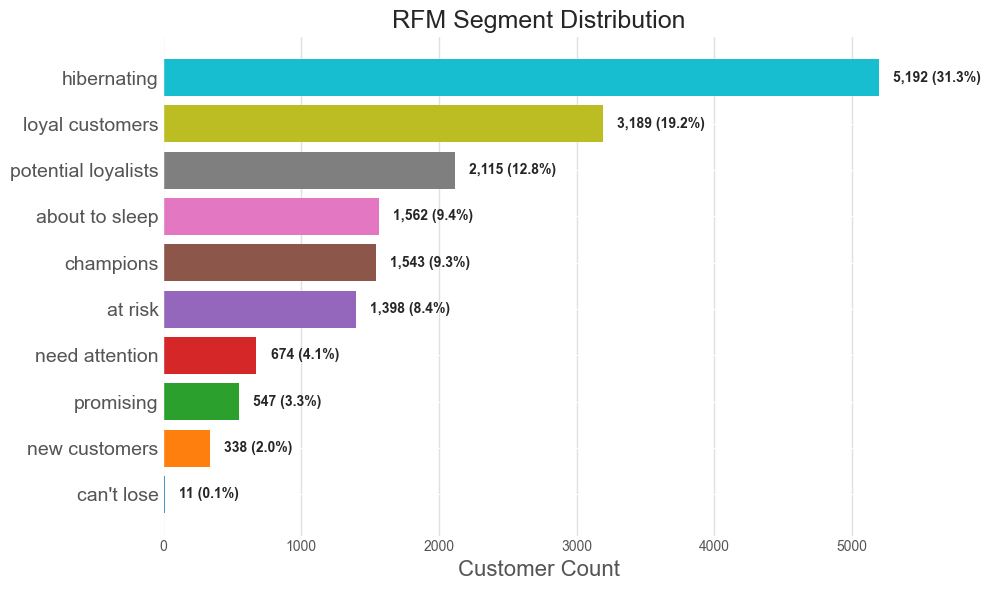

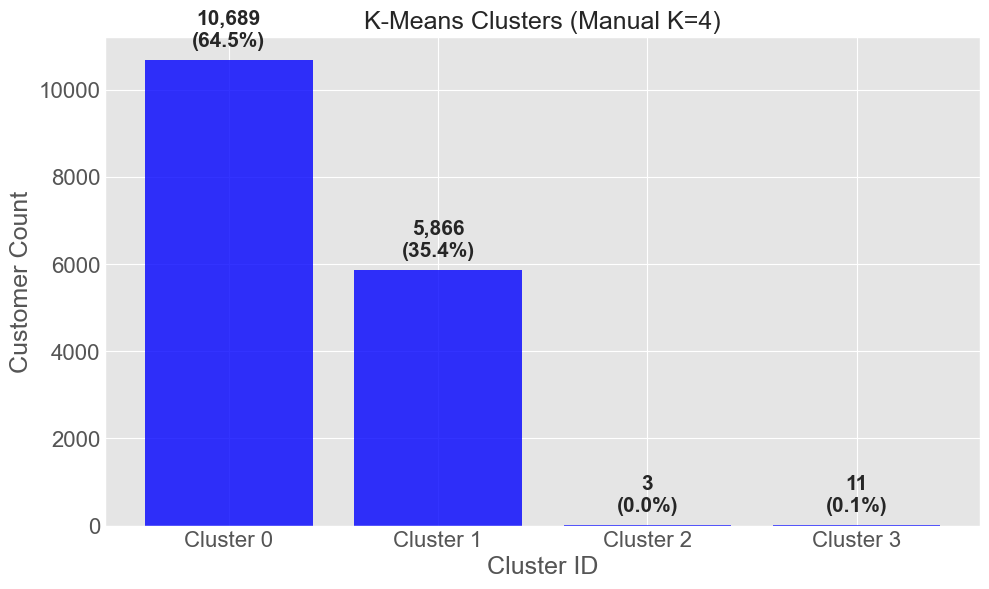

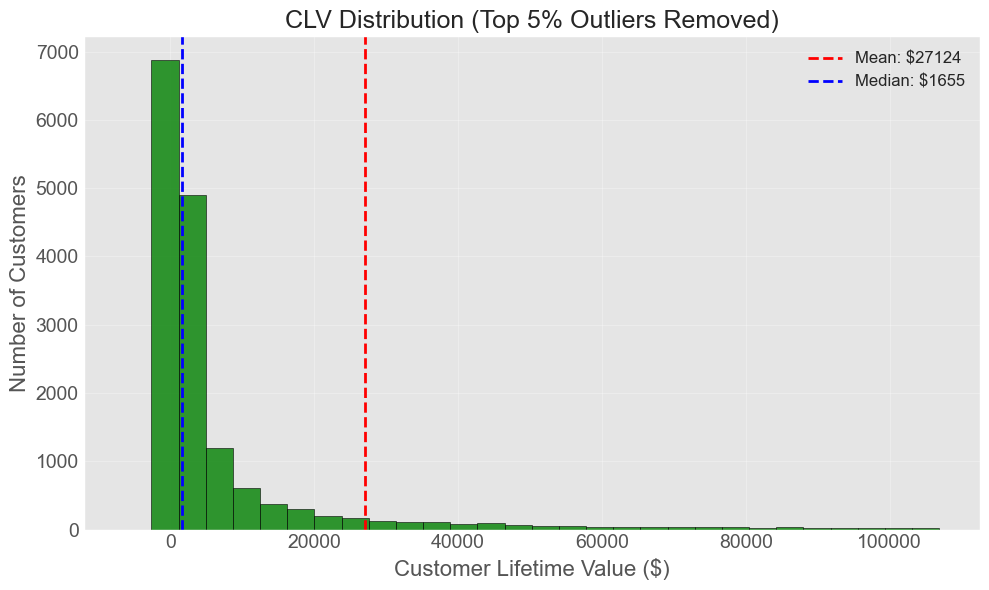

CLV Visualization: Top 5% outliers removed (above $106958)
Displayed CLV range: $0 - $106958
Number of outliers removed: 829


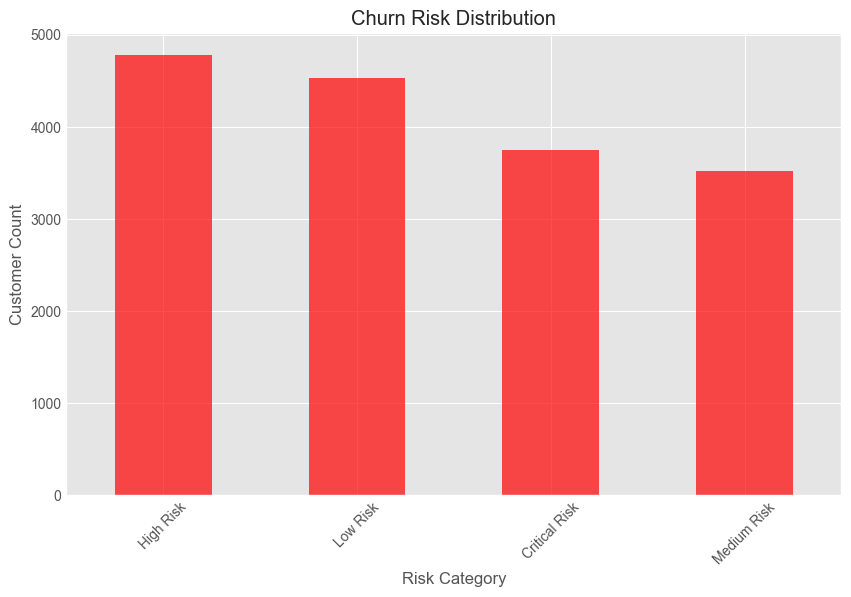

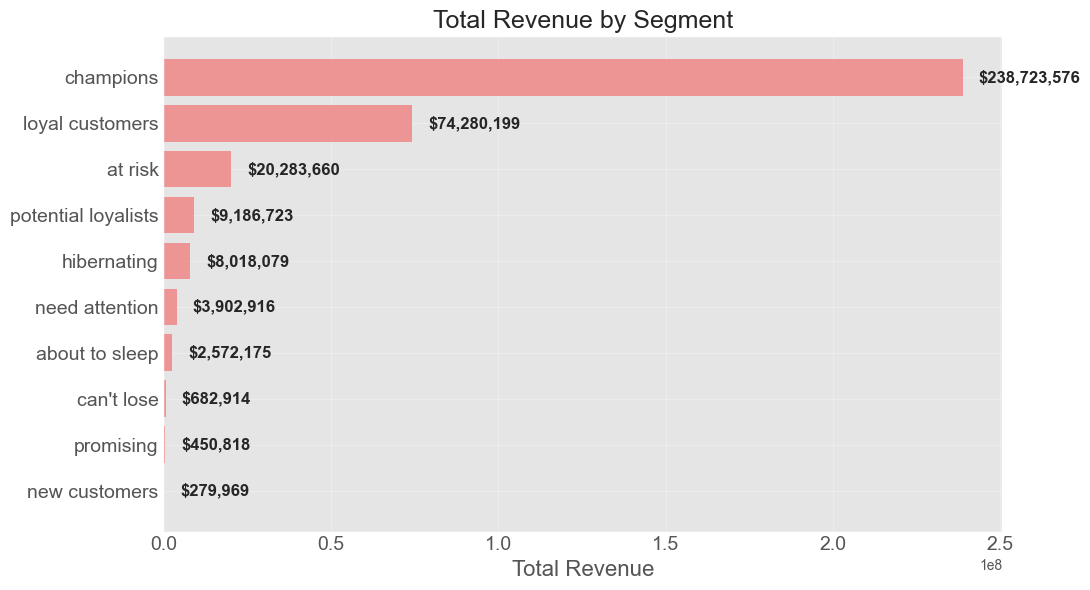

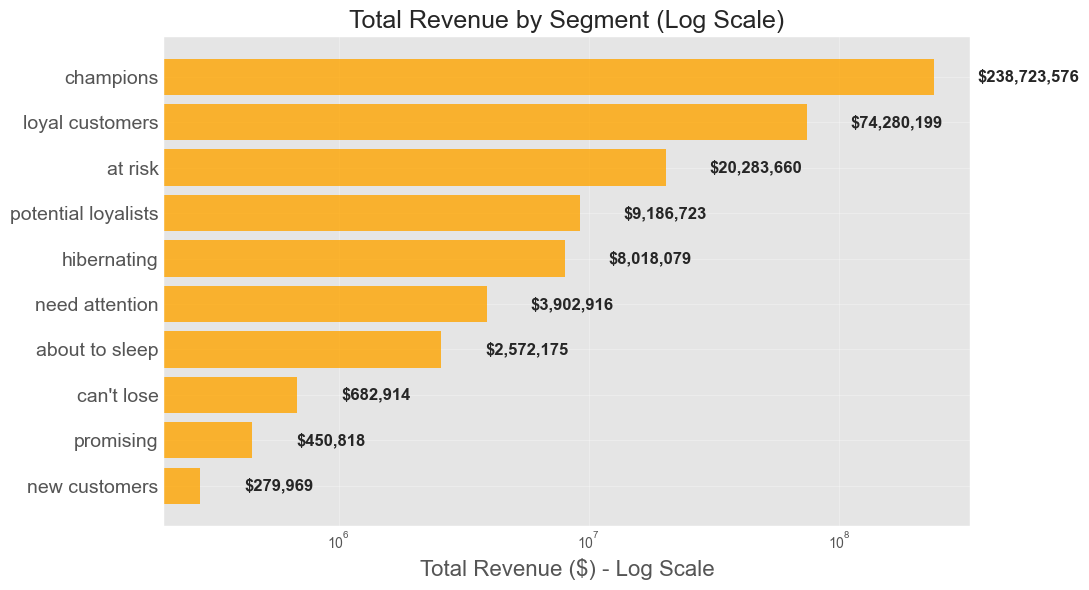

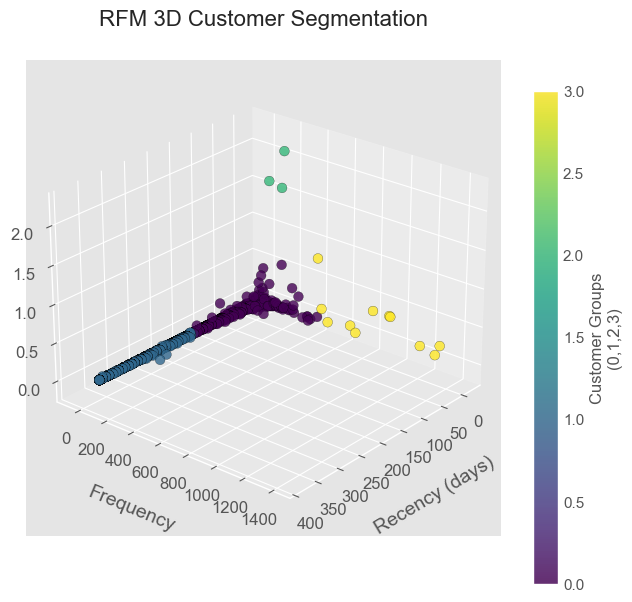

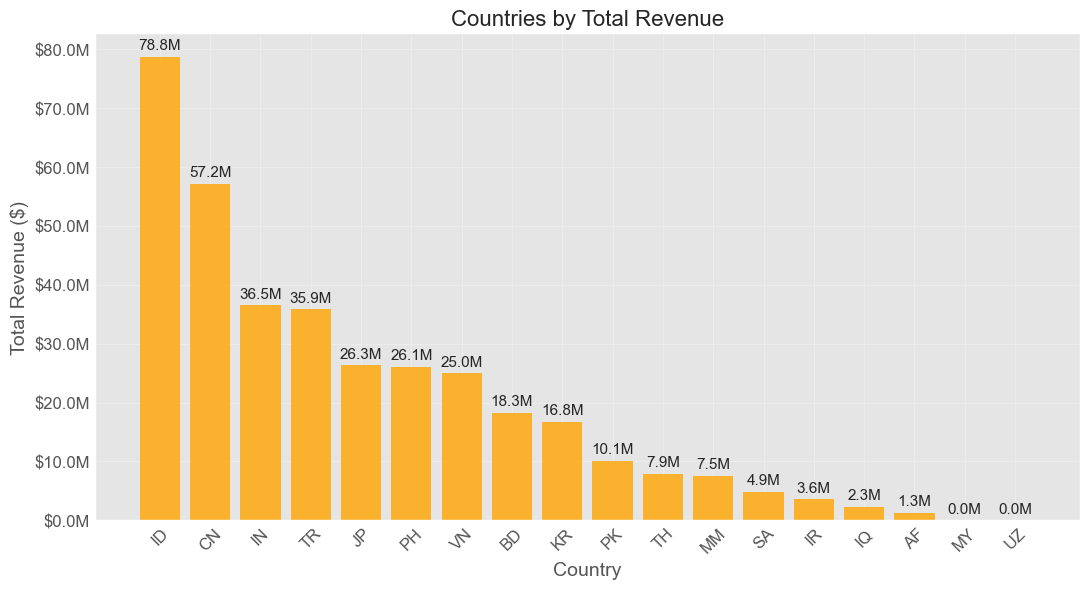

Total 18 countries displayed


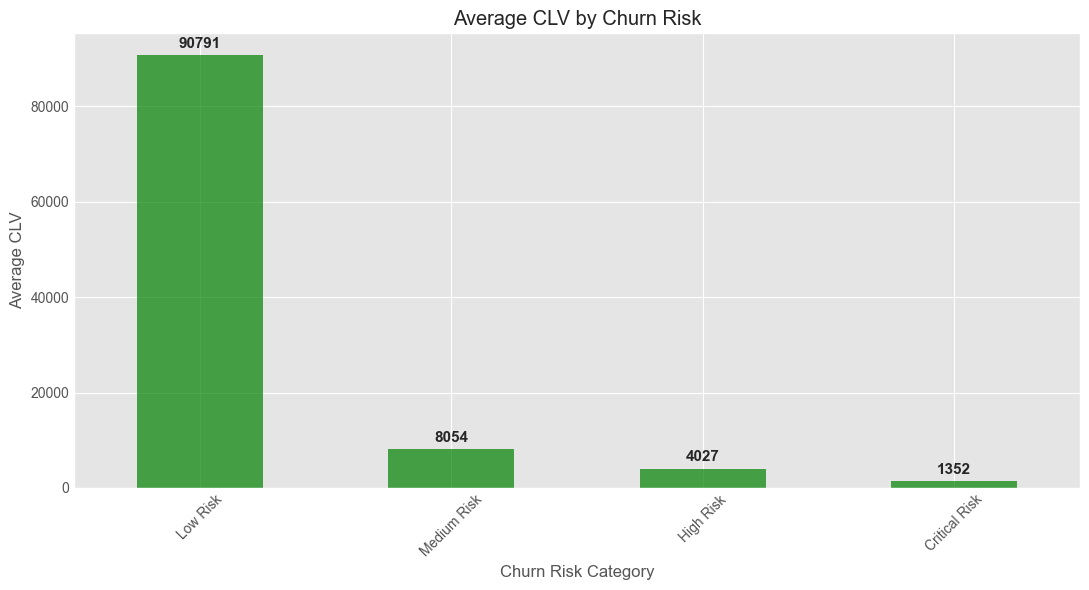

In [36]:
segment_counts = rfm['segment'].value_counts()
plt.figure(figsize=(10, 6))
segment_counts_sorted = segment_counts.sort_values(ascending=True)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

bars = plt.barh(range(len(segment_counts_sorted)), segment_counts_sorted.values,
                color=colors[:len(segment_counts_sorted)])

plt.yticks(range(len(segment_counts_sorted)), segment_counts_sorted.index, fontsize=14)
plt.xlabel('Customer Count', fontsize=16)
plt.title('RFM Segment Distribution', fontsize=18)

plt.gca().set_facecolor('white')
plt.gcf().patch.set_facecolor('white')

plt.grid(True, axis='x', alpha=0.7, linestyle='-', linewidth=1, color='lightgray')
plt.gca().set_axisbelow(True)

for i, (segment, count) in enumerate(segment_counts_sorted.items()):
    percentage = count / segment_counts.sum() * 100
    plt.text(count + max(segment_counts_sorted.values) * 0.02, i,
             f'{count:,} ({percentage:.1f}%)',
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
cluster_counts = rfm['kmeans_cluster'].value_counts().sort_index()
bars = plt.bar(range(len(cluster_counts)), cluster_counts.values, color='blue', alpha=0.8)
plt.title('K-Means Clusters (Manual K=4)', fontsize=18)
plt.xlabel('Cluster ID', fontsize=18)
plt.ylabel('Customer Count', fontsize=18)
plt.xticks(range(len(cluster_counts)), [f'Cluster {i}' for i in cluster_counts.index], fontsize=16)
plt.yticks(fontsize=16)

total_customers = cluster_counts.sum()
for i, (cluster_id, count) in enumerate(cluster_counts.items()):
   percentage = count / total_customers * 100
   plt.text(i, count + max(cluster_counts.values) * 0.02,
            f'{count:,}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
clv_95th = clv_data['clv'].quantile(0.95)
clv_filtered = clv_data['clv'][clv_data['clv'] <= clv_95th]

plt.hist(clv_filtered, bins=30, alpha=0.8, color='green', edgecolor='black', linewidth=0.5)
plt.title('CLV Distribution (Top 5% Outliers Removed)', fontsize=18)
plt.xlabel('Customer Lifetime Value ($)', fontsize=16)
plt.ylabel('Number of Customers', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, alpha=0.3)

mean_clv = clv_data['clv'].mean()
median_clv = clv_data['clv'].median()
plt.axvline(mean_clv, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_clv:.0f}')
plt.axvline(median_clv, color='blue', linestyle='--', linewidth=2, label=f'Median: ${median_clv:.0f}')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

print(f"CLV Visualization: Top 5% outliers removed (above ${clv_95th:.0f})")
print(f"Displayed CLV range: $0 - ${clv_95th:.0f}")
print(f"Number of outliers removed: {len(clv_data) - len(clv_filtered)}")

plt.figure(figsize=(10, 6))
churn_features['churn_risk_category'].value_counts().plot(kind='bar', color='red', alpha=0.7)
plt.title('Churn Risk Distribution')
plt.xlabel('Risk Category')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(11, 6))
segment_revenue = rfm.groupby('segment')['monetary'].sum().sort_values(ascending=True)
bars = plt.barh(range(len(segment_revenue)), segment_revenue.values, color='lightcoral', alpha=0.8)
plt.yticks(range(len(segment_revenue)), segment_revenue.index, fontsize=14)
plt.title('Total Revenue by Segment', fontsize=18)
plt.xlabel('Total Revenue', fontsize=16)
plt.xticks(fontsize=14)
plt.grid(True, alpha=0.3)

for i, (segment, revenue) in enumerate(segment_revenue.items()):
   plt.text(revenue + max(segment_revenue.values) * 0.02, i, 
            f'${revenue:,.0f}', 
            va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 6))
segment_revenue = rfm.groupby('segment')['monetary'].sum().sort_values(ascending=True)
bars = plt.barh(range(len(segment_revenue)), segment_revenue.values, color='orange', alpha=0.8)
plt.yticks(range(len(segment_revenue)), segment_revenue.index, fontsize=14)
plt.xscale('log')
plt.title('Total Revenue by Segment (Log Scale)', fontsize=18)
plt.xlabel('Total Revenue ($) - Log Scale', fontsize=16)
plt.grid(True, alpha=0.3)

for i, (segment, revenue) in enumerate(segment_revenue.items()):
   plt.text(revenue * 1.5, i,
            f'${revenue:,.0f}', 
            va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 2, 2, projection='3d')

scatter = ax.scatter(rfm['recency'], rfm['frequency'], rfm['monetary'],
                    c=rfm['kmeans_cluster'], cmap='viridis', 
                    s=50, alpha=0.8, edgecolors='black', linewidth=0.2)

ax.set_xlabel('Recency (days)', fontsize=14, labelpad=12)
ax.set_ylabel('Frequency', fontsize=14, labelpad=12)
ax.set_zlabel('Monetary ($)', fontsize=14, labelpad=25)

ax.set_title('RFM 3D Customer Segmentation', fontsize=16, pad=25)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='z', labelsize=12)

ax.view_init(elev=25, azim=40)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.1)
cbar.set_label('Customer Groups\n(0,1,2,3)', fontsize=12)
cbar.ax.tick_params(labelsize=11)

pos = ax.get_position()
ax.set_position([pos.x0-0.15, pos.y0-0.05, pos.width*1.6, pos.height*1.5])

ax.margins(x=0.1, y=0.1, z=0.1)
plt.show()

plt.figure(figsize=(11, 6))
country_revenue = rfm.groupby('country')['monetary'].sum().sort_values(ascending=False)
bars = plt.bar(range(len(country_revenue)), country_revenue.values, color='orange', alpha=0.8)
plt.xticks(range(len(country_revenue)), country_revenue.index, rotation=45, fontsize=12)
plt.title('Countries by Total Revenue', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Total Revenue ($)', fontsize=14)
plt.yticks(fontsize=12)

plt.ticklabel_format(style='plain', axis='y')

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

for i, (country, revenue) in enumerate(country_revenue.items()):
   plt.text(i, revenue + max(country_revenue.values) * 0.01, 
            f'{revenue/1e6:.1f}M', 
            ha='center', va='bottom', fontsize=11)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total {len(country_revenue)} countries displayed")

plt.figure(figsize=(11, 6))
churn_clv_merged = churn_features[['customer_id', 'churn_risk_category']].merge(
   clv_data[['customer_id', 'clv']], on='customer_id', how='left'
)
churn_clv = churn_clv_merged.groupby('churn_risk_category')['clv'].mean()

bars = churn_clv.plot(kind='bar', color='green', alpha=0.7)
plt.title('Average CLV by Churn Risk')
plt.xlabel('Churn Risk Category')
plt.ylabel('Average CLV')
plt.xticks(rotation=45)

ax = plt.gca()
for i, (category, value) in enumerate(churn_clv.items()):
   plt.text(i, value + max(churn_clv.values) * 0.01, 
            f'{value:.0f}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [37]:
rfm.to_csv('../output/rfm_sales.csv', encoding='utf-8', index=False, float_format='%.2f')
print("\nRFM analysis completed and saved to '../output/rfm_sales.csv'")


RFM analysis completed and saved to '../output/rfm_sales.csv'


In [38]:
segment_summary = rfm.groupby('segment').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean', 
    'monetary': ['mean', 'sum']
}).round(2)

segment_summary.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue']
segment_summary['Revenue_Percentage'] = (segment_summary['Total_Revenue'] / segment_summary['Total_Revenue'].sum() * 100).round(2)
segment_summary['Customer_Percentage'] = (segment_summary['Customer_Count'] / len(rfm) * 100).round(2)

print("Segment Summary:")
print(segment_summary.sort_values('Total_Revenue', ascending=False))

Segment Summary:
                     Customer_Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
segment                                                                         
champions                      1543         6.66          40.05     154713.92   
loyal customers                3189        36.16          11.27      23292.63   
at risk                        1398       202.89           4.61      14509.06   
potential loyalists            2115        24.42           3.39       4343.60   
hibernating                    5192       247.90           1.33       1544.31   
need attention                  674        82.18           3.97       5790.68   
about to sleep                 1562        83.99           1.58       1646.72   
can't lose                       11       277.82          21.91      62083.06   
promising                       547        36.08           1.13        824.16   
new customers                   338         9.51           1.17        828.31   

          

In [39]:
country_analysis = rfm.groupby('country').agg({
    'customer_id': 'count',
    'monetary': ['mean', 'sum'],
    'frequency': 'mean',
    'recency': 'mean'
}).round(2)

country_analysis.columns = ['Customer_Count', 'Avg_Monetary', 'Total_Revenue', 'Avg_Frequency', 'Avg_Recency']
country_analysis['Revenue_Per_Customer'] = (country_analysis['Total_Revenue'] / country_analysis['Customer_Count']).round(2)
country_analysis = country_analysis.sort_values('Total_Revenue', ascending=False)

print("Country Performance (Top 10):")
print(country_analysis.head(10))

Country Performance (Top 10):
         Customer_Count  Avg_Monetary  Total_Revenue  Avg_Frequency  \
country                                                               
ID                 3660      21520.50    78765035.64           7.62   
CN                 1935      29537.88    57155806.50           5.64   
IN                 1582      23070.97    36498277.86           8.50   
TR                  423      84797.32    35869267.32          12.03   
JP                  425      61997.58    26348970.18           7.99   
PH                 1075      24302.28    26124951.18           9.84   
VN                 1752      14243.16    24954008.04           8.85   
BD                 1531      11932.93    18269311.86           5.52   
KR                  568      29504.64    16758633.72          13.92   
PK                 1363       7393.94    10077946.74           4.06   

         Avg_Recency  Revenue_Per_Customer  
country                                     
ID            102.18       

In [40]:
recency_ranges = pd.cut(rfm['recency'], bins=[0, 30, 60, 90, 180, 365], 
                       labels=['0-30 days', '31-60 days', '61-90 days', '91-180 days', '180+ days'])

recency_analysis = rfm.groupby(recency_ranges, observed=True).agg({
    'customer_id': 'count',
    'monetary': 'sum'
})
recency_analysis.columns = ['Customer_Count', 'Total_Revenue']

print("Distribution by Last Purchase Time:")
print(recency_analysis)

print("\nDetailed Analysis:")
for period, data in recency_analysis.iterrows():
    avg_revenue = data['Total_Revenue'] / data['Customer_Count']
    print(f"   {period}: {data['Customer_Count']:,} customers, "
          f"Total: ${data['Total_Revenue']:,.0f}, "
          f"Avg per customer: ${avg_revenue:.2f}")

Distribution by Last Purchase Time:
             Customer_Count  Total_Revenue
recency                                   
0-30 days              5289   2.853859e+08
31-60 days             2135   2.312315e+07
61-90 days             1493   1.163593e+07
91-180 days            2872   2.187677e+07
180+ days              4780   1.635932e+07

Detailed Analysis:
   0-30 days: 5,289.0 customers, Total: $285,385,858, Avg per customer: $53958.38
   31-60 days: 2,135.0 customers, Total: $23,123,147, Avg per customer: $10830.51
   61-90 days: 1,493.0 customers, Total: $11,635,929, Avg per customer: $7793.66
   91-180 days: 2,872.0 customers, Total: $21,876,770, Avg per customer: $7617.26
   180+ days: 4,780.0 customers, Total: $16,359,323, Avg per customer: $3422.45


In [41]:
total_customers = len(rfm)
total_revenue = rfm['monetary'].sum()
avg_customer_value = total_revenue / total_customers

risk_segments = ['at risk', 'about to sleep', "can't lose", 'hibernating']
risk_customers = rfm[rfm['segment'].isin(risk_segments)]
risk_percentage = len(risk_customers) / total_customers * 100
risk_revenue = risk_customers['monetary'].sum()
risk_revenue_percentage = risk_revenue / total_revenue * 100

print(f"\nGeneral Metrics:")
print(f"   - Total customers: {total_customers:,}")
print(f"   - Total revenue: ${total_revenue:,.2f}")
print(f"   - Average customer value: ${avg_customer_value:.2f}")
print(f"   - Customers at risk: {risk_percentage:.1f}% ({len(risk_customers):,} customers)")
print(f"   - Revenue at risk: {risk_revenue_percentage:.1f}% (${risk_revenue:,.2f})")


General Metrics:
   - Total customers: 16,569
   - Total revenue: $358,381,027.14
   - Average customer value: $21629.61
   - Customers at risk: 49.3% (8,163 customers)
   - Revenue at risk: 8.8% ($31,556,827.20)


In [42]:
champions = rfm[rfm['segment'] == 'champions']
if len(champions) > 0:
    print(f"1. CHAMPIONS ({len(champions)} customers):")
    print(f"   - Average revenue: ${champions['monetary'].mean():.2f}")
    print(f"   - Total revenue: ${champions['monetary'].sum():.2f}")
    print(f"   - Action: VIP program, special discounts, early access")

at_risk = rfm[rfm['segment'] == 'at risk']
if len(at_risk) > 0:
    print(f"\n2. AT RISK ({len(at_risk)} customers):")
    print(f"   - Average last purchase: {at_risk['recency'].mean():.0f} days ago")
    print(f"   - Total potential loss: ${at_risk['monetary'].sum():.2f}")
    print(f"   - Action: Personalized campaigns, win-back emails")

cant_lose = rfm[rfm['segment'] == "can't lose"]
if len(cant_lose) > 0:
    print(f"\n3. CAN'T LOSE ({len(cant_lose)} customers):")
    print(f"   - Average revenue: ${cant_lose['monetary'].mean():.2f}")
    print(f"   - Total potential loss: ${cant_lose['monetary'].sum():.2f}")
    print(f"   - Action: URGENT intervention! Phone calls, special offers")

new_customers = rfm[rfm['segment'] == 'new customers']
if len(new_customers) > 0:
    print(f"\n4. NEW CUSTOMERS ({len(new_customers)} customers):")
    print(f"   - Average first purchase: ${new_customers['monetary'].mean():.2f}")
    print(f"   - Action: Welcome campaign, onboarding processes")

1. CHAMPIONS (1543 customers):
   - Average revenue: $154713.92
   - Total revenue: $238723575.54
   - Action: VIP program, special discounts, early access

2. AT RISK (1398 customers):
   - Average last purchase: 203 days ago
   - Total potential loss: $20283659.94
   - Action: Personalized campaigns, win-back emails

3. CAN'T LOSE (11 customers):
   - Average revenue: $62083.06
   - Total potential loss: $682913.70
   - Action: URGENT intervention! Phone calls, special offers

4. NEW CUSTOMERS (338 customers):
   - Average first purchase: $828.31
   - Action: Welcome campaign, onboarding processes


In [43]:
high_potential_segments = ['at risk', 'need attention', 'about to sleep']
high_potential = rfm[rfm['segment'].isin(high_potential_segments)]

if len(high_potential) > 0:
    total_potential = high_potential['monetary'].sum()
    print(f"\n$ Recoverable Revenue Potential:")
    print(f"   - Total: ${total_potential:.2f}")
    print(f"   - Customer count: {len(high_potential):,}")
    print(f"   - Average customer value: ${total_potential/len(high_potential):.2f}")


$ Recoverable Revenue Potential:
   - Total: $26758751.28
   - Customer count: 3,634
   - Average customer value: $7363.44


In [44]:
country_segments = rfm.groupby(['country', 'segment']).size().unstack(fill_value=0)
dominant_segments = country_segments.idxmax(axis=1)

print("\nDominant Segments by Country (ALL COUNTRIES):")
for country, segment in dominant_segments.items():
    customer_count = country_segments.loc[country, segment]
    total_customers_country = country_segments.loc[country].sum()
    percentage = (customer_count / total_customers_country * 100)
    print(f"   {country}: {segment} ({percentage:.1f}% - {customer_count} customers)")

print(f"\nTOP 10 Countries by Customer Count:")
top_countries = rfm['country'].value_counts().head(10)
for country, count in top_countries.items():
    print(f"   {country}: {count} customers")


Dominant Segments by Country (ALL COUNTRIES):
   AF: hibernating (37.6% - 77 customers)
   BD: hibernating (35.8% - 548 customers)
   CN: hibernating (42.0% - 813 customers)
   ID: hibernating (26.2% - 958 customers)
   IN: hibernating (25.8% - 408 customers)
   IQ: hibernating (29.4% - 37 customers)
   IR: hibernating (34.8% - 172 customers)
   JP: hibernating (45.4% - 193 customers)
   KR: hibernating (28.7% - 163 customers)
   MM: hibernating (32.3% - 193 customers)
   MY: potential loyalists (100.0% - 1 customers)
   PH: hibernating (28.8% - 310 customers)
   PK: hibernating (35.1% - 479 customers)
   SA: loyal customers (23.4% - 57 customers)
   TH: hibernating (27.1% - 159 customers)
   TR: hibernating (28.6% - 121 customers)
   UZ: hibernating (100.0% - 1 customers)
   VN: hibernating (28.9% - 506 customers)

TOP 10 Countries by Customer Count:
   ID: 3660 customers
   CN: 1935 customers
   VN: 1752 customers
   IN: 1582 customers
   BD: 1531 customers
   PK: 1363 customers
   

In [45]:
with pd.ExcelWriter('../output/advanced_rfm_report.xlsx', engine='openpyxl') as writer:
    rfm.to_excel(writer, sheet_name='RFM_Data', index=False)
    
    rfm[['customer_id', 'kmeans_cluster', 'dbscan_cluster', 'segment']].to_excel(
        writer, sheet_name='Clustering_Results', index=False)
    
    clv_data[['customer_id', 'clv', 'clv_quartile', 'aov', 'purchase_frequency_yearly']].to_excel(
        writer, sheet_name='CLV_Analysis', index=False)
    
    churn_features[['customer_id', 'churn_risk_score', 'churn_risk_category', 
                   'recency_risk', 'frequency_risk', 'monetary_risk']].to_excel(
        writer, sheet_name='Churn_Risk', index=False)
    
    segment_summary.to_excel(writer, sheet_name='Segment_Summary')
    
    country_analysis.to_excel(writer, sheet_name='Country_Analysis')
    
    recency_analysis.to_excel(writer, sheet_name='Recency_Analysis')
    
    retention_table.to_excel(writer, sheet_name='Cohort_Analysis')
    
    clv_rfm_comparison.to_excel(writer, sheet_name='CLV_RFM_Comparison')

print("\nAdvanced analysis completed and saved to '../output/advanced_rfm_report.xlsx'")


Advanced analysis completed and saved to '../output/advanced_rfm_report.xlsx'


In [46]:
print(f"\nKey Statistics:")
print(f"   - Total customers: {total_customers:,}")
print(f"   - Optimal K-Means clusters: {optimal_k}")
print(f"   - DBSCAN cluster count: {n_clusters_dbscan}")
print(f"   - Average CLV: ${clv_data['clv'].mean():.2f}")
print(f"   - Critical risk customers: {len(critical_customers):,}")

print(f"\nBusiness Value:")
print(f"   - Total revenue: ${total_revenue:,.2f}")
print(f"   - Revenue at risk: ${risk_revenue:,.2f} ({risk_revenue_percentage:.1f}%)")
print(f"   - Recoverable potential: ${total_potential:.2f}")

print(f"\nModel Performance Metrics:")
print(f"   - K-Means Silhouette Score: {max(silhouette_scores):.3f}")
print(f"   - Number of segments: {len(rfm['segment'].unique())}")
print(f"   - CLV variation: {clv_data['clv'].std():.2f}")


Key Statistics:
   - Total customers: 16,569
   - Optimal K-Means clusters: 2
   - DBSCAN cluster count: 86
   - Average CLV: $27123.87
   - Critical risk customers: 3,745

Business Value:
   - Total revenue: $358,381,027.14
   - Revenue at risk: $31,556,827.20 (8.8%)
   - Recoverable potential: $26758751.28

Model Performance Metrics:
   - K-Means Silhouette Score: 0.969
   - Number of segments: 10
   - CLV variation: 123027.68


In [47]:
try:
    if 'client' in locals():
        client.close()
        print("\nDask client closed")
except:
    pass


Dask client closed
